In [ ]:
import os
import warnings
import importlib
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, confusion_matrix, f1_score, accuracy_score, \
    precision_score, recall_score
import xgboost as xgb
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, confusion_matrix, f1_score
from sklearn.model_selection import KFold, LeavePGroupsOut
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
import matplotlib
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from tabpfn import TabPFNClassifier
from sklearn.preprocessing import label_binarize
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.utils.class_weight import compute_sample_weight
import shap
from catboost import CatBoostClassifier

%matplotlib inline
# matplotlib.use('TkAgg')
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler  # install via: pip install imbalanced-learn

warnings.filterwarnings('ignore')
from scipy.stats import skew
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

seed = 69
torch.manual_seed(seed)
np.random.seed(seed)



sundowning = False
current = True

timescale = '06h'


label = 'agitation-next'       # detection     prediction
weighted = True                # weighted      unweighted
kfold = False                   # kfold         lopo

results_dir = '/home/ali/PycharmProjects/tihm/results/current-lopo'

os.makedirs(results_dir, exist_ok=False)

True
NVIDIA GeForce RTX 3080 Ti Laptop GPU


In [102]:
root = '/home/ali/PycharmProjects/tihm/dataset'

if timescale == '06h':
    dataset = pd.read_csv(os.path.join(root, 'data-06h.csv'))
elif timescale == '12h':
    dataset = pd.read_csv(os.path.join(root, 'data-12h.csv'))
elif timescale == '24h':
    dataset = pd.read_csv(os.path.join(root, 'data-24h.csv'))

display(dataset.shape)

(10790, 69)

In [103]:
# display(dataset)

print(dataset['agitation'].equals(dataset['agitation-next']))

print(np.sum(dataset['agitation']))
print(np.sum(dataset['agitation-next']))

print(np.where(dataset['agitation'] == 1))
print(np.where(dataset['agitation-next'] == 1))

print(np.sum(dataset['agitation'] == 0),
      np.sum(dataset['agitation'] == 1))

print(np.sum(dataset['agitation-next'] == 0),
      np.sum(dataset['agitation-next'] == 1))

print(np.sum(dataset['agitation-four'] == 0),
      np.sum(dataset['agitation-four'] == 1),
      np.sum(dataset['agitation-four'] == 2),
      np.sum(dataset['agitation-four'] == 3))


# display(dataset)
print(dataset.columns.values)

False
135.0
135.0
(array([  117,   358,   528,   532,   536,   537,   552,   564,   568,
         572,   597,   661,   669,   923,   935,   940,   944,   963,
         967,   983,  1039,  1044,  1055,  1074,  1662,  2660,  2986,
        3010,  3163,  4157,  4261,  4439,  4442,  4454,  4460,  4464,
        4467,  4468,  4470,  4471,  4472,  4474,  4476,  4480,  4482,
        4483,  4484,  4487,  4488,  4491,  4492,  4495,  4504,  4506,
        4507,  4515,  4519,  4520,  4530,  4532,  4555,  4571,  4579,
        4593,  4692,  4740,  4741,  4748,  4764,  4772,  4792,  4891,
        5066,  5067,  5195,  5386,  5503,  5504,  5523,  5543,  5564,
        5567,  5587,  5591,  5600,  5622,  5626,  5649,  5827,  5828,
        6034,  6120,  6152,  6156,  6164,  6185,  6204,  7192,  7197,
        7241,  7384,  7493,  7501,  7502,  7509,  7517,  7518,  7525,
        7533,  7534,  7537,  7541,  7568,  8661,  8976,  8977,  9070,
        9074,  9087,  9094,  9103,  9186,  9426,  9470,  9514,  9526,
 

In [104]:
# Agitation Statistics

temp = dataset.copy()

temp['agitation'].fillna(0, inplace=True)


print(f"Total number of participants: {temp['id'].nunique()}")
print(f"Total number of participants with at least one agitation episode: {temp[temp['agitation'] == 1]['id'].nunique()}")
print(f"Total number of participants with no agitation episodes: {temp['id'].nunique() - temp[temp['agitation'] == 1]['id'].nunique()}")
print(f"Total number of agitation episodes: {(temp['agitation'] == 1).sum()}")


ids, total_counts = np.unique(temp['id'], return_counts=True)
agitated_ids, agitation_counts = np.unique(temp[temp['agitation'] == 1]['id'], return_counts=True)
agitation_map = dict(zip(agitated_ids, agitation_counts))
unique_dates = temp.groupby('id')['date'].nunique().reindex(ids, fill_value=0).values
participant_summary_df = pd.DataFrame({
    'participant_id': ids,
    'six_hour_sample_count': total_counts,
    'unique_dates': unique_dates,
    'agitation_episodes': [agitation_map.get(pid, 0) for pid in ids]
})
participant_summary_df = participant_summary_df.sort_values(by='agitation_episodes', ascending=False).reset_index(drop=True)
# display(participant_summary_df)


# values, counts = np.unique(temp.loc[temp['agitation'] == 1, '6h'], return_counts=True)
# values, counts = np.unique(temp.loc[temp['agitation'] == 1, '12h'], return_counts=True)
# values, counts = np.unique(temp.loc[temp['agitation'] == 1], return_counts=True)

# agitation_temporal_df = pd.DataFrame({
#     '6h_time_block': values,
#     'agitation_episode_count': counts
# })
# display(agitation_temporal_df)

Total number of participants: 56
Total number of participants with at least one agitation episode: 27
Total number of participants with no agitation episodes: 29
Total number of agitation episodes: 135


In [105]:
# 03

if timescale == '06h':
    columns_indices = ['id', 'date', '6h']
elif timescale == '12h':
    columns_indices = ['id', 'date', '12h']
elif timescale == '24h':
    columns_indices = ['id', 'date']

# 08
columns_count = ['back-door', 'bathroom', 'bedroom', 'fridge-door',
                 'front-door', 'hallway', 'kitchen', 'lounge']

# 08
columns_contextual = ['total-events', 'unique-locations', 'active-location-ratio', 'private-to-public-ratio',
                      'location-entropy', 'location-dominance-ratio', 'back-and-forth-count', 'num-transitions']

# 32
columns_statistical = ['back-door-count-max', 'back-door-count-mean', 'back-door-count-std', 'back-door-count-sum',
                       'bathroom-count-max', 'bathroom-count-mean', 'bathroom-count-std', 'bathroom-count-sum',
                       'bedroom-count-max', 'bedroom-count-mean', 'bedroom-count-std', 'bedroom-count-sum',
                       'fridge-door-count-max', 'fridge-door-count-mean', 'fridge-door-count-std', 'fridge-door-count-sum',
                       'front-door-count-max', 'front-door-count-mean', 'front-door-count-std', 'front-door-count-sum',
                       'hallway-count-max', 'hallway-count-mean', 'hallway-count-std', 'hallway-count-sum',
                       'kitchen-count-max', 'kitchen-count-mean', 'kitchen-count-std','kitchen-count-sum',
                       'lounge-count-max', 'lounge-count-mean', 'lounge-count-std','lounge-count-sum']

# 08
columns_physiology = ['body-temperature', 'body-weight', 'diastolic-blood-pressure', 'heart-rate',
                      'muscle-mass', 'systolic-blood-pressure', 'total-body-water', 'skin-temperature']

# 06
columns_labels = ['blood-pressure', 'agitation', 'body-water', 'pulse', 'weight', 'body-temperature-label']

# 02
columns_demographics = ['age', 'sex']

# 02
columns_prediction = ['agitation-next', 'agitation-four']

print(len(columns_count),
      len(columns_statistical),
      len(columns_contextual),
      len(columns_physiology),
      len(columns_demographics),
      len(columns_labels))



8 32 8 8 2 6


In [106]:
columns = columns_indices + columns_count + columns_contextual + columns_statistical + columns_physiology + columns_labels + columns_demographics + columns_prediction
print(dataset.columns.to_list())
print(columns)

print(columns == dataset.columns.to_list())


y = np.array(dataset[[label]]).squeeze()

if label == 'agitation' or label == 'agitation-next':
    y[y == -1] = 0
    y[y >= 1] = 1
elif label == 'agitation-four':
    y[y == -1] = 0
    y[y == -10] = 0

ids = np.array(dataset['id']).squeeze()
p = np.unique(ids, return_inverse=True)[1]

print(np.isnan(y).sum())
print(np.isnan(p).sum())

y = np.nan_to_num(y, nan=0)

print(np.isnan(y).sum())
print(np.isnan(p).sum())

print(np.unique(y))
print(y.sum())


# To Drop
if not current:
    dataset.drop(columns_count + columns_demographics + columns_prediction + columns_labels, axis=1, inplace=True)
else:
    dataset.drop(columns_count + columns_demographics + columns_prediction
                 + list(set(columns_labels) - set(['agitation'])), axis=1, inplace=True)
    dataset['agitation'] = dataset['agitation'].apply(lambda x: 0 if x == -1 else (1 if x >= 1 else x))


print(dataset.columns.to_list())

display('y: ', y)
display('p: ', p)
display('dataset: ', dataset)


['id', 'date', '6h', 'back-door', 'bathroom', 'bedroom', 'fridge-door', 'front-door', 'hallway', 'kitchen', 'lounge', 'total-events', 'unique-locations', 'active-location-ratio', 'private-to-public-ratio', 'location-entropy', 'location-dominance-ratio', 'back-and-forth-count', 'num-transitions', 'back-door-count-max', 'back-door-count-mean', 'back-door-count-std', 'back-door-count-sum', 'bathroom-count-max', 'bathroom-count-mean', 'bathroom-count-std', 'bathroom-count-sum', 'bedroom-count-max', 'bedroom-count-mean', 'bedroom-count-std', 'bedroom-count-sum', 'fridge-door-count-max', 'fridge-door-count-mean', 'fridge-door-count-std', 'fridge-door-count-sum', 'front-door-count-max', 'front-door-count-mean', 'front-door-count-std', 'front-door-count-sum', 'hallway-count-max', 'hallway-count-mean', 'hallway-count-std', 'hallway-count-sum', 'kitchen-count-max', 'kitchen-count-mean', 'kitchen-count-std', 'kitchen-count-sum', 'lounge-count-max', 'lounge-count-mean', 'lounge-count-std', 'lounge

'y: '

array([0., 0., 0., ..., 0., 0., 0.], shape=(10790,))

'p: '

array([ 0,  0,  0, ..., 55, 55, 55], shape=(10790,))

'dataset: '

,id,date,6h,total-events,unique-locations,active-location-ratio,private-to-public-ratio,location-entropy,location-dominance-ratio,back-and-forth-count,...,lounge-count-sum,body-temperature,body-weight,diastolic-blood-pressure,heart-rate,muscle-mass,systolic-blood-pressure,total-body-water,skin-temperature,agitation
0,0697d,2019-06-28,00-06,0.0,0.0,0.000,1.0000,0.0000,0.0000,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,0697d,2019-06-28,06-12,0.0,0.0,0.000,1.0000,0.0000,0.0000,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,0697d,2019-06-28,12-18,221.0,8.0,1.000,0.1691,2.7340,0.2579,35.0,...,49.0,36.1864,86.3,82.0,42.0,64.5,165.0,50.6,NaN,0.0
3,0697d,2019-06-28,18-24,101.0,7.0,0.875,0.0889,1.8916,0.4851,22.0,...,31.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,0697d,2019-06-29,00-06,3.0,1.0,0.125,1.0000,-0.0000,1.0000,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10785,fd100,2019-06-29,12-18,182.0,7.0,0.875,0.2283,2.5224,0.3077,31.0,...,46.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10786,fd100,2019-06-29,18-24,114.0,7.0,0.875,0.3671,2.4755,0.2982,19.0,...,34.0,36.2400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10787,fd100,2019-06-30,00-06,0.0,0.0,0.000,1.0000,0.0000,0.0000,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10788,fd100,2019-06-30,06-12,146.0,7.0,0.875,0.5465,2.5379,0.2603,10.0,...,31.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [107]:
# Imputation
import utils_data
importlib.reload(utils_data)
from utils_data import hierarchical_imputation
from sklearn.preprocessing import OrdinalEncoder



print(dataset.isna().sum().sum())

dataset = hierarchical_imputation(dataset)

print(dataset.isna().sum().sum())

if not sundowning:
    dataset.drop(columns_indices, axis=1, inplace=True)
else:
    dataset.drop(list(set(columns_indices)
                      - set(['6h'])), axis=1, inplace=True)
    dataset['6h'] = dataset['6h'].map({k: i for i, k in enumerate(sorted(dataset['6h'].unique()))})

98769
0


In [108]:
x = np.array(dataset)

print(x.shape)
print(y.shape)

np.save(os.path.join('/home/ali/PycharmProjects/tihm/xyp', 'x.npy'), x)
np.save(os.path.join('/home/ali/PycharmProjects/tihm/xyp', 'y.npy'), y)
np.save(os.path.join('/home/ali/PycharmProjects/tihm/xyp', 'p.npy'), p)


print(np.unique(y))

feature_names = dataset.columns.values
print(feature_names)
display(dataset)

(10790, 50)
(10790,)
[0. 1.]
['6h' 'total-events' 'unique-locations' 'active-location-ratio'
 'private-to-public-ratio' 'location-entropy' 'location-dominance-ratio'
 'back-and-forth-count' 'num-transitions' 'back-door-count-max'
 'back-door-count-mean' 'back-door-count-std' 'back-door-count-sum'
 'bathroom-count-max' 'bathroom-count-mean' 'bathroom-count-std'
 'bathroom-count-sum' 'bedroom-count-max' 'bedroom-count-mean'
 'bedroom-count-std' 'bedroom-count-sum' 'fridge-door-count-max'
 'fridge-door-count-mean' 'fridge-door-count-std' 'fridge-door-count-sum'
 'front-door-count-max' 'front-door-count-mean' 'front-door-count-std'
 'front-door-count-sum' 'hallway-count-max' 'hallway-count-mean'
 'hallway-count-std' 'hallway-count-sum' 'kitchen-count-max'
 'kitchen-count-mean' 'kitchen-count-std' 'kitchen-count-sum'
 'lounge-count-max' 'lounge-count-mean' 'lounge-count-std'
 'lounge-count-sum' 'body-temperature' 'body-weight'
 'diastolic-blood-pressure' 'heart-rate' 'muscle-mass'
 'systoli

,6h,total-events,unique-locations,active-location-ratio,private-to-public-ratio,location-entropy,location-dominance-ratio,back-and-forth-count,num-transitions,back-door-count-max,...,lounge-count-sum,body-temperature,body-weight,diastolic-blood-pressure,heart-rate,muscle-mass,systolic-blood-pressure,total-body-water,skin-temperature,agitation
0,0,0.0,0.0,0.000,1.0000,0.0000,0.0000,0.0,0.0,0.0,...,0.0,36.5675,69.1708,75.6146,72.1250,47.5853,136.4271,49.8206,34.2843,0.0000
1,1,0.0,0.0,0.000,1.0000,0.0000,0.0000,0.0,0.0,0.0,...,0.0,36.5675,69.1708,75.6146,72.1250,47.5853,136.4271,49.8206,34.2843,0.0000
2,2,221.0,8.0,1.000,0.1691,2.7340,0.2579,35.0,155.0,11.0,...,49.0,36.1864,86.3000,82.0000,42.0000,64.5000,165.0000,50.6000,34.2843,0.0000
3,3,101.0,7.0,0.875,0.0889,1.8916,0.4851,22.0,61.0,1.0,...,31.0,36.5675,69.1708,75.6146,72.1250,47.5853,136.4271,49.8206,34.2843,0.0000
4,0,3.0,1.0,0.125,1.0000,-0.0000,1.0000,0.0,1.0,0.0,...,0.0,36.5425,71.7159,74.1458,76.0469,48.6600,130.7188,51.7600,34.5600,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10785,2,182.0,7.0,0.875,0.2283,2.5224,0.3077,31.0,139.0,0.0,...,46.0,36.5425,71.7159,74.1458,76.0469,48.6600,130.7188,51.7600,34.5600,0.0938
10786,3,114.0,7.0,0.875,0.3671,2.4755,0.2982,19.0,92.0,0.0,...,34.0,36.2400,71.7159,74.1458,76.0469,48.6600,130.7188,51.7600,34.5600,0.0938
10787,0,0.0,0.0,0.000,1.0000,0.0000,0.0000,0.0,0.0,0.0,...,0.0,36.7593,68.9053,73.7692,70.3526,46.2964,134.0000,51.1929,34.6478,0.0000
10788,1,146.0,7.0,0.875,0.5465,2.5379,0.2603,10.0,110.0,0.0,...,31.0,36.7593,68.9053,73.7692,70.3526,46.2964,134.0000,51.1929,34.6478,0.0000


In [109]:
# LightGBM

name = 'LightGBM'.lower()

Y_TRUES = np.empty([0])
Y_PROBS = np.empty([0])
Y_PREDS = np.empty([0])




# Explainability
importances_list = []
shap_list = []
x_test_list = []


if kfold:
    cv = KFold(n_splits=5, shuffle=True, random_state=seed)
    split_iterator = cv.split(x)
else:
    cv = LeavePGroupsOut(n_groups=1)
    split_iterator = cv.split(x, y, groups=p)

for i, (train_idx, test_idx) in enumerate(split_iterator, start=1):
    participant = i if kfold else np.unique(p[test_idx])[0]



    x_train, x_test = x[train_idx], x[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    print(participant, x_train.shape[0], x_test.shape[0])

    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)

    normalizer = MinMaxScaler()
    normalizer.fit(x_train)
    x_train = normalizer.transform(x_train)
    x_test = normalizer.transform(x_test)

    # Oversample class 1

    # ros = RandomOverSampler(sampling_strategy=.1, random_state=seed)
    # x_train, y_train = ros.fit_resample(x_train, y_train)

    # 1. Check original class distribution
    # print("Original class distribution:", Counter(y_train))
    # # 2. Define the minority class (adjust if needed)
    # minority_class = 1  # change this if your minority class label is different
    # current_minority_count = sum(y_train == minority_class)
    # # 3. Define desired new total count for the minority class (10x)
    # target_minority_count = current_minority_count * 10
    # # 4. Setup SMOTE with custom sampling strategy
    # smote = SMOTE(sampling_strategy={minority_class: target_minority_count}, random_state=seed)
    # # 5. Fit and resample
    # x_train, y_train = smote.fit_resample(x_train, y_train)
    # # 6. Confirm new distribution
    # print("Resampled class distribution:", Counter(y_train))



    # ----- LightGBM
    train_data = lgb.Dataset(x_train, label=y_train)
    test_data = lgb.Dataset(x_test, label=y_test, reference=train_data)
    params = {
        'verbose': -1,  # 👈 turn off training output
        'objective': 'binary',
        'metric': 'binary_logloss',  # or 'auc' if you prefer
        'num_leaves': 64,
        'learning_rate': 0.01,
        'n_estimators': 100,
        
        'is_unbalance': weighted  # Automatically balances positive and negative classes

        # 'scale_pos_weight': (y_train == 0).sum() / (y_train == 1).sum()
    }
    model = lgb.train(params, train_data, valid_sets=[train_data, test_data])
    y_probs = model.predict(x_test, num_iteration=model.best_iteration)
    

    Y_TRUES = np.append(Y_TRUES, y_test)
    Y_PROBS = np.append(Y_PROBS, y_probs)
    Y_PREDS = np.append(Y_PREDS, (y_probs >= .5).astype(int))



    # Explainability
    # importances = model.feature_importance(importance_type='gain')
    importances = model.feature_importance(importance_type='split')
    importances_list.append(importances)


    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(x_test)
    shap_list.append(shap_values)
    x_test_list.append(x_test)





indx = Y_TRUES.argsort()
Y_TRUES = Y_TRUES[indx]
Y_PROBS = Y_PROBS[indx]
Y_PREDS = Y_PREDS[indx]


# Evaluation metrics
auc_roc = roc_auc_score(Y_TRUES, Y_PROBS)
precision, recall, _ = precision_recall_curve(Y_TRUES, Y_PROBS)
auc_pr = auc(recall, precision)
acc = accuracy_score(Y_TRUES, Y_PREDS)
pre = precision_score(Y_TRUES, Y_PREDS)
rec = recall_score(Y_TRUES, Y_PREDS)
f1 = f1_score(Y_TRUES, Y_PREDS)

# Confusion matrix: [ [TN, FP], [FN, TP] ]
tn, fp, fn, tp = confusion_matrix(Y_TRUES, Y_PREDS).ravel()

# Sensitivity = Recall = TP / (TP + FN)
sensitivity = tp / (tp + fn)

# Specificity = TN / (TN + FP)
specificity = tn / (tn + fp)

results = {
    'auc-roc': f"{auc_roc:.4f}",
    'auc-pr': f"{auc_pr:.4f}",
    'accuracy': f"{acc:.4f}",
    'precision': f"{pre:.4f}",
    'recall': f"{rec:.4f}",
    'f1-score': f"{f1:.4f}",
    'sensitivity': f"{sensitivity:.4f}",
    'specificity': f"{specificity:.4f}",
    'tn': str(int(tn)),
    'fp': str(int(fp)),
    'fn': str(int(fn)),
    'tp': str(int(tp))
}


results = pd.DataFrame([results])
results.to_csv(os.path.join(results_dir, name + '.csv'), index=False)
display(results)


0 10779 11
1 10617 173
2 10488 302
3 10599 191
4 10604 186
5 10767 23
6 10437 353
7 10541 249
8 10500 290
9 10611 179
10 10771 19
11 10560 230
12 10532 258
13 10716 74
14 10524 266
15 10548 242
16 10665 125
17 10508 282
18 10668 122
19 10570 220
20 10588 202
21 10521 269
22 10627 163
23 10600 190
24 10771 19
25 10520 270
26 10495 295
27 10520 270
28 10605 185
29 10616 174
30 10576 214
31 10556 234
32 10687 103
33 10560 230
34 10625 165
35 10751 39
36 10525 265
37 10436 354
38 10621 169
39 10463 327
40 10524 266
41 10584 206
42 10632 158
43 10520 270
44 10728 62
45 10699 91
46 10763 27
47 10580 210
48 10672 118
49 10528 262
50 10627 163
51 10541 249
52 10502 288
53 10575 215
54 10532 258
55 10775 15


,auc-roc,auc-pr,accuracy,precision,recall,f1-score,sensitivity,specificity,tn,fp,fn,tp
0,0.9199,0.4209,0.9885,0.5733,0.3185,0.4095,0.3185,0.9970,10623,32,92,43


50 (50,) (10790, 50) (10790,) (15, 50) (15,)


,feature,importance
31,hallway-count-std,525.5714
8,num-transitions,364.0714
39,lounge-count-std,294.9643
49,agitation,281.6250
41,body-temperature,257.1964
44,heart-rate,255.1429
6,location-dominance-ratio,229.3750
0,6h,228.7679
4,private-to-public-ratio,227.2321
1,total-events,213.8393


(10790, 50)


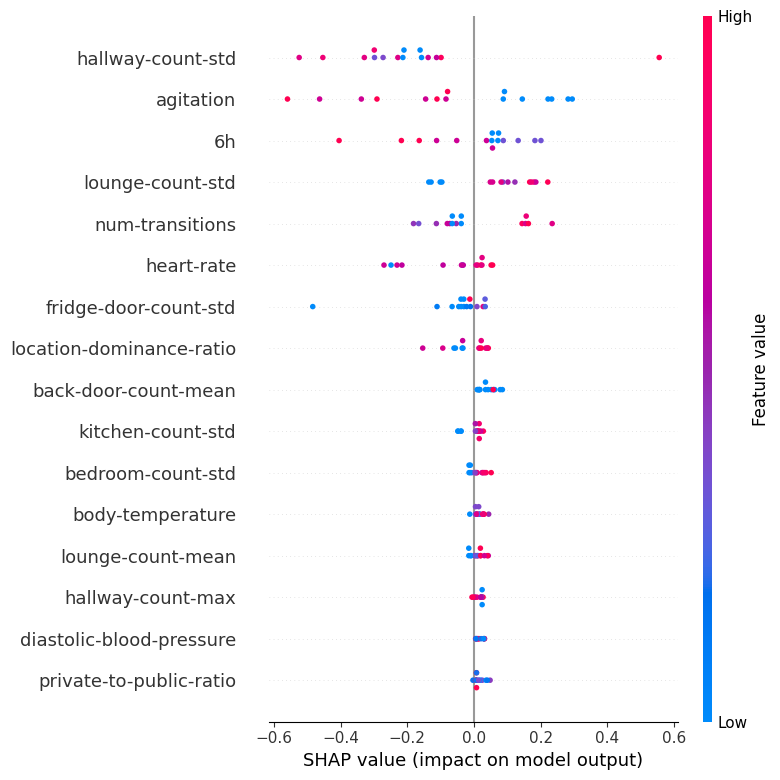

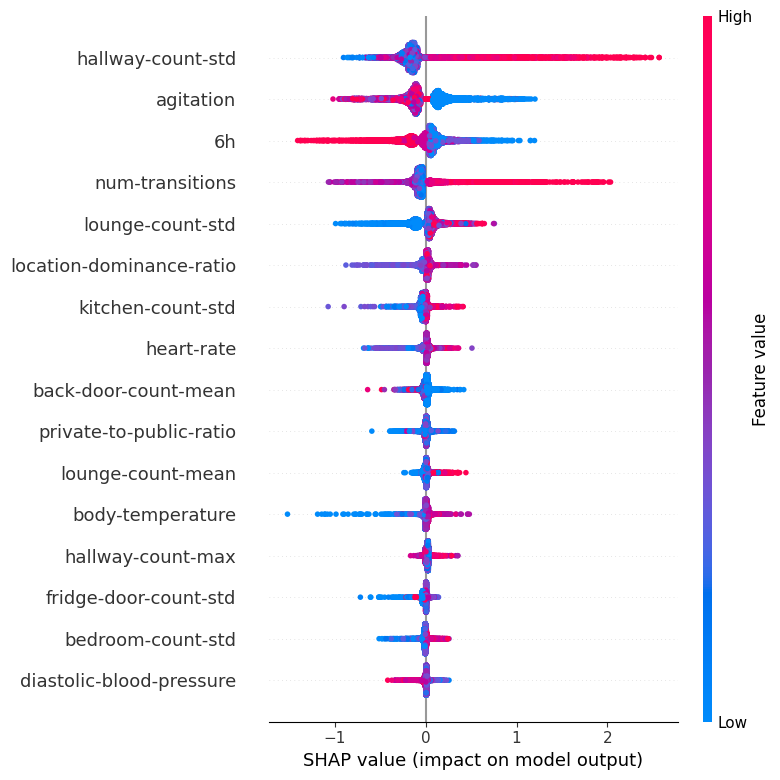

In [110]:
# Explainability

print(len(feature_names), np.vstack(importances_list).mean(axis=0).round(4).shape, x.shape, y.shape, x_test.shape, y_test.shape)

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': np.vstack(importances_list).mean(axis=0).round(4)
}).sort_values(by='importance', ascending=False)
display(importance_df)
importance_df.to_csv('importance.csv', index=False)


# Create DataFrame for summary
shap_df = pd.DataFrame({
    'feature': feature_names,
    'mean_abs_shap': np.abs(np.vstack(shap_list)).mean(axis=0).round(4)
}).sort_values(by='mean_abs_shap', ascending=False)
shap_df.to_csv('importance-shap.csv', index=False)

print(np.vstack(x_test_list).shape)

shap.summary_plot(shap_values, pd.DataFrame(x_test, columns=feature_names), max_display=16)
shap.summary_plot(np.vstack(shap_list), pd.DataFrame(np.vstack(x_test_list), columns=feature_names), max_display=16)



In [111]:
# Transformer

if not weighted:

    name = 'Transformer'.lower()

    Y_TRUES = np.empty([0])
    Y_PROBS = np.empty([0])
    Y_PREDS = np.empty([0])


    if kfold:
        cv = KFold(n_splits=5, shuffle=True, random_state=seed)
        split_iterator = cv.split(x)
    else:
        cv = LeavePGroupsOut(n_groups=1)
        split_iterator = cv.split(x, y, groups=p)

    for i, (train_idx, test_idx) in enumerate(split_iterator, start=1):
        participant = i if kfold else np.unique(p[test_idx])[0]

        x_train, x_test = x[train_idx], x[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        print(participant, x_train.shape[0], x_test.shape[0])

        scaler = StandardScaler()
        scaler.fit(x_train)
        x_train = scaler.transform(x_train)
        x_test = scaler.transform(x_test)

        normalizer = MinMaxScaler()
        normalizer.fit(x_train)
        x_train = normalizer.transform(x_train)
        x_test = normalizer.transform(x_test)

        # Oversample class 1

        # ros = RandomOverSampler(sampling_strategy=.1, random_state=seed)
        # x_train, y_train = ros.fit_resample(x_train, y_train)

        # # 1. Check original class distribution
        # print("Original class distribution:", Counter(y_train))
        # # 2. Define the minority class (adjust if needed)
        # minority_class = 1  # change this if your minority class label is different
        # current_minority_count = sum(y_train == minority_class)
        # # 3. Define desired new total count for the minority class (10x)
        # target_minority_count = current_minority_count * 10
        # # 4. Setup SMOTE with custom sampling strategy
        # smote = SMOTE(sampling_strategy={minority_class: target_minority_count}, random_state=seed)
        # # 5. Fit and resample
        # x_train, y_train = smote.fit_resample(x_train, y_train)
        # # 6. Confirm new distribution
        # print("Resampled class distribution:", Counter(y_train))



        # ----- LightGBM
        # train_data = lgb.Dataset(x_train, label=y_train)
        # test_data = lgb.Dataset(x_test, label=y_test, reference=train_data)
        # params = {
        #     'verbose': -1,  # 👈 turn off training output
        #     'objective': 'binary',
        #     'metric': 'binary_logloss',  # or 'auc' if you prefer
        #     'num_leaves': 64,
        #     'learning_rate': 0.01,
        #     'n_estimators': 100,
        #     # 'is_unbalance': True  # Automatically balances positive and negative classes
        #     # 'scale_pos_weight': (y_train == 0).sum() / (y_train == 1).sum()
        # }
        # bst = lgb.train(params, train_data, valid_sets=[train_data, test_data])
        # y_probs = bst.predict(x_test, num_iteration=bst.best_iteration)


        # ----- Transformer
        model = TabPFNClassifier(
            device='cuda',
            random_state=seed,
            n_estimators = 4,
            ignore_pretraining_limits=True)
        model.fit(x_train, y_train)
        y_probs = model.predict_proba(x_test)[:, 1]


        Y_TRUES = np.append(Y_TRUES, y_test)
        Y_PROBS = np.append(Y_PROBS, y_probs)
        Y_PREDS = np.append(Y_PREDS, (y_probs >= .5).astype(int))


    indx = Y_TRUES.argsort()
    Y_TRUES = Y_TRUES[indx]
    Y_PROBS = Y_PROBS[indx]
    Y_PREDS = Y_PREDS[indx]


    # Evaluation metrics
    auc_roc = roc_auc_score(Y_TRUES, Y_PROBS)
    precision, recall, _ = precision_recall_curve(Y_TRUES, Y_PROBS)
    auc_pr = auc(recall, precision)
    acc = accuracy_score(Y_TRUES, Y_PREDS)
    pre = precision_score(Y_TRUES, Y_PREDS)
    rec = recall_score(Y_TRUES, Y_PREDS)
    f1 = f1_score(Y_TRUES, Y_PREDS)

    # Confusion matrix: [ [TN, FP], [FN, TP] ]
    tn, fp, fn, tp = confusion_matrix(Y_TRUES, Y_PREDS).ravel()

    # Sensitivity = Recall = TP / (TP + FN)
    sensitivity = tp / (tp + fn)

    # Specificity = TN / (TN + FP)
    specificity = tn / (tn + fp)

    results = {
        'auc-roc': f"{auc_roc:.4f}",
        'auc-pr': f"{auc_pr:.4f}",
        'accuracy': f"{acc:.4f}",
        'precision': f"{pre:.4f}",
        'recall': f"{rec:.4f}",
        'f1-score': f"{f1:.4f}",
        'sensitivity': f"{sensitivity:.4f}",
        'specificity': f"{specificity:.4f}",
        'tn': str(int(tn)),
        'fp': str(int(fp)),
        'fn': str(int(fn)),
        'tp': str(int(tp))
    }


    results = pd.DataFrame([results])
    results.to_csv(os.path.join(results_dir, name + '.csv'), index=False)
    display(results)

In [112]:
# Gradient Boosting Classifier

name = 'Gradient-Boosting'.lower()

Y_TRUES = np.empty([0])
Y_PROBS = np.empty([0])
Y_PREDS = np.empty([0])


if kfold:
    cv = KFold(n_splits=5, shuffle=True, random_state=seed)
    split_iterator = cv.split(x)
else:
    cv = LeavePGroupsOut(n_groups=1)
    split_iterator = cv.split(x, y, groups=p)

for i, (train_idx, test_idx) in enumerate(split_iterator, start=1):
    participant = i if kfold else np.unique(p[test_idx])[0]

    x_train, x_test = x[train_idx], x[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    print(participant, x_train.shape[0], x_test.shape[0])

    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)

    normalizer = MinMaxScaler()
    normalizer.fit(x_train)
    x_train = normalizer.transform(x_train)
    x_test = normalizer.transform(x_test)

    # Oversample class 1

    # ros = RandomOverSampler(sampling_strategy=.1, random_state=seed)
    # x_train, y_train = ros.fit_resample(x_train, y_train)

    # # 1. Check original class distribution
    # print("Original class distribution:", Counter(y_train))
    # # 2. Define the minority class (adjust if needed)
    # minority_class = 1  # change this if your minority class label is different
    # current_minority_count = sum(y_train == minority_class)
    # # 3. Define desired new total count for the minority class (10x)
    # target_minority_count = current_minority_count * 10
    # # 4. Setup SMOTE with custom sampling strategy
    # smote = SMOTE(sampling_strategy={minority_class: target_minority_count}, random_state=seed)
    # # 5. Fit and resample
    # x_train, y_train = smote.fit_resample(x_train, y_train)
    # # 6. Confirm new distribution
    # print("Resampled class distribution:", Counter(y_train))


    # ----- LightGBM
    # train_data = lgb.Dataset(x_train, label=y_train)
    # test_data = lgb.Dataset(x_test, label=y_test, reference=train_data)
    # params = {
    #     'verbose': -1,  # 👈 turn off training output
    #     'objective': 'binary',
    #     'metric': 'binary_logloss',  # or 'auc' if you prefer
    #     'num_leaves': 64,
    #     'learning_rate': 0.01,
    #     'n_estimators': 100,
    #     # 'is_unbalance': True  # Automatically balances positive and negative classes
    #     # 'scale_pos_weight': (y_train == 0).sum() / (y_train == 1).sum()
    # }
    # bst = lgb.train(params, train_data, valid_sets=[train_data, test_data])
    # y_probs = bst.predict(x_test, num_iteration=bst.best_iteration)


    # ----- Transformer
    # model = TabPFNClassifier(
    #     device='cuda',
    #     random_state=seed,
    #     n_estimators = 4,
    #     ignore_pretraining_limits=True)
    # model.fit(x_train, y_train)
    # y_probs = model.predict_proba(x_test)[:, 1]


    # ----- Gradient Boosting Classifier
    model = GradientBoostingClassifier(
        n_estimators=100,  # match LightGBM
        learning_rate=0.001,  # match LightGBM
        max_depth=4,  # similar to LightGBM default tree depth
        subsample=1.0,  # default
        random_state=seed
    )
    if weighted:
        model.fit(x_train, y_train, sample_weight=compute_sample_weight(class_weight='balanced', y=y_train))
    else:
        model.fit(x_train, y_train)
    

    y_probs = model.predict_proba(x_test)[:, 1]
    

    Y_TRUES = np.append(Y_TRUES, y_test)
    Y_PROBS = np.append(Y_PROBS, y_probs)
    Y_PREDS = np.append(Y_PREDS, (y_probs >= .5).astype(int))


indx = Y_TRUES.argsort()
Y_TRUES = Y_TRUES[indx]
Y_PROBS = Y_PROBS[indx]
Y_PREDS = Y_PREDS[indx]


# Evaluation metrics
auc_roc = roc_auc_score(Y_TRUES, Y_PROBS)
precision, recall, _ = precision_recall_curve(Y_TRUES, Y_PROBS)
auc_pr = auc(recall, precision)
acc = accuracy_score(Y_TRUES, Y_PREDS)
pre = precision_score(Y_TRUES, Y_PREDS)
rec = recall_score(Y_TRUES, Y_PREDS)
f1 = f1_score(Y_TRUES, Y_PREDS)

# Confusion matrix: [ [TN, FP], [FN, TP] ]
tn, fp, fn, tp = confusion_matrix(Y_TRUES, Y_PREDS).ravel()

# Sensitivity = Recall = TP / (TP + FN)
sensitivity = tp / (tp + fn)

# Specificity = TN / (TN + FP)
specificity = tn / (tn + fp)

results = {
    'auc-roc': f"{auc_roc:.4f}",
    'auc-pr': f"{auc_pr:.4f}",
    'accuracy': f"{acc:.4f}",
    'precision': f"{pre:.4f}",
    'recall': f"{rec:.4f}",
    'f1-score': f"{f1:.4f}",
    'sensitivity': f"{sensitivity:.4f}",
    'specificity': f"{specificity:.4f}",
    'tn': str(int(tn)),
    'fp': str(int(fp)),
    'fn': str(int(fn)),
    'tp': str(int(tp))
}


results = pd.DataFrame([results])
results.to_csv(os.path.join(results_dir, name + '.csv'), index=False)
display(results)

0 10779 11
1 10617 173
2 10488 302
3 10599 191
4 10604 186
5 10767 23
6 10437 353
7 10541 249
8 10500 290
9 10611 179
10 10771 19
11 10560 230
12 10532 258
13 10716 74
14 10524 266
15 10548 242
16 10665 125
17 10508 282
18 10668 122
19 10570 220
20 10588 202
21 10521 269
22 10627 163
23 10600 190
24 10771 19
25 10520 270
26 10495 295
27 10520 270
28 10605 185
29 10616 174
30 10576 214
31 10556 234
32 10687 103
33 10560 230
34 10625 165
35 10751 39
36 10525 265
37 10436 354
38 10621 169
39 10463 327
40 10524 266
41 10584 206
42 10632 158
43 10520 270
44 10728 62
45 10699 91
46 10763 27
47 10580 210
48 10672 118
49 10528 262
50 10627 163
51 10541 249
52 10502 288
53 10575 215
54 10532 258
55 10775 15


,auc-roc,auc-pr,accuracy,precision,recall,f1-score,sensitivity,specificity,tn,fp,fn,tp
0,0.9423,0.2119,0.8335,0.0608,0.8519,0.1135,0.8519,0.8333,8879,1776,20,115


In [113]:
# XGBoost

name = 'XGBoost'.lower()

Y_TRUES = np.empty([0])
Y_PROBS = np.empty([0])
Y_PREDS = np.empty([0])


if kfold:
    cv = KFold(n_splits=5, shuffle=True, random_state=seed)
    split_iterator = cv.split(x)
else:
    cv = LeavePGroupsOut(n_groups=1)
    split_iterator = cv.split(x, y, groups=p)

for i, (train_idx, test_idx) in enumerate(split_iterator, start=1):
    participant = i if kfold else np.unique(p[test_idx])[0]

    x_train, x_test = x[train_idx], x[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    print(participant, x_train.shape[0], x_test.shape[0])

    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)

    normalizer = MinMaxScaler()
    normalizer.fit(x_train)
    x_train = normalizer.transform(x_train)
    x_test = normalizer.transform(x_test)

    # Oversample class 1

    # ros = RandomOverSampler(sampling_strategy=.1, random_state=seed)
    # x_train, y_train = ros.fit_resample(x_train, y_train)

    # # 1. Check original class distribution
    # print("Original class distribution:", Counter(y_train))
    # # 2. Define the minority class (adjust if needed)
    # minority_class = 1  # change this if your minority class label is different
    # current_minority_count = sum(y_train == minority_class)
    # # 3. Define desired new total count for the minority class (10x)
    # target_minority_count = current_minority_count * 10
    # # 4. Setup SMOTE with custom sampling strategy
    # smote = SMOTE(sampling_strategy={minority_class: target_minority_count}, random_state=seed)
    # # 5. Fit and resample
    # x_train, y_train = smote.fit_resample(x_train, y_train)
    # # 6. Confirm new distribution
    # print("Resampled class distribution:", Counter(y_train))


    # ----- LightGBM
    # train_data = lgb.Dataset(x_train, label=y_train)
    # test_data = lgb.Dataset(x_test, label=y_test, reference=train_data)
    # params = {
    #     'verbose': -1,  # 👈 turn off training output
    #     'objective': 'binary',
    #     'metric': 'binary_logloss',  # or 'auc' if you prefer
    #     'num_leaves': 64,
    #     'learning_rate': 0.01,
    #     'n_estimators': 100,
    #     # 'is_unbalance': True  # Automatically balances positive and negative classes
    #     # 'scale_pos_weight': (y_train == 0).sum() / (y_train == 1).sum()
    # }
    # bst = lgb.train(params, train_data, valid_sets=[train_data, test_data])
    # y_probs = bst.predict(x_test, num_iteration=bst.best_iteration)


    # ----- Transformer
    # model = TabPFNClassifier(
    #     device='cuda',
    #     random_state=seed,
    #     n_estimators = 4,
    #     ignore_pretraining_limits=True)
    # model.fit(x_train, y_train)
    # y_probs = model.predict_proba(x_test)[:, 1]


    # ----- Gradient Boosting Classifier
    # model = GradientBoostingClassifier(
    #     n_estimators=100,  # match LightGBM
    #     learning_rate=0.001,  # match LightGBM
    #     max_depth=4,  # similar to LightGBM default tree depth
    #     subsample=1.0,  # default
    #     random_state=seed
    # )
    # model.fit(x_train, y_train)
    # y_probs = model.predict_proba(x_test)[:, 1]
    

    # ----- XGBoost
    model = XGBClassifier()
    if weighted:
        model.fit(x_train, y_train, sample_weight=compute_sample_weight(class_weight='balanced', y=y_train))
    else:
        model.fit(x_train, y_train)
    y_probs = model.predict_proba(x_test)[:, 1]


    Y_TRUES = np.append(Y_TRUES, y_test)
    Y_PROBS = np.append(Y_PROBS, y_probs)
    Y_PREDS = np.append(Y_PREDS, (y_probs >= .5).astype(int))


indx = Y_TRUES.argsort()
Y_TRUES = Y_TRUES[indx]
Y_PROBS = Y_PROBS[indx]
Y_PREDS = Y_PREDS[indx]


# Evaluation metrics
auc_roc = roc_auc_score(Y_TRUES, Y_PROBS)
precision, recall, _ = precision_recall_curve(Y_TRUES, Y_PROBS)
auc_pr = auc(recall, precision)
acc = accuracy_score(Y_TRUES, Y_PREDS)
pre = precision_score(Y_TRUES, Y_PREDS)
rec = recall_score(Y_TRUES, Y_PREDS)
f1 = f1_score(Y_TRUES, Y_PREDS)

# Confusion matrix: [ [TN, FP], [FN, TP] ]
tn, fp, fn, tp = confusion_matrix(Y_TRUES, Y_PREDS).ravel()

# Sensitivity = Recall = TP / (TP + FN)
sensitivity = tp / (tp + fn)

# Specificity = TN / (TN + FP)
specificity = tn / (tn + fp)

results = {
    'auc-roc': f"{auc_roc:.4f}",
    'auc-pr': f"{auc_pr:.4f}",
    'accuracy': f"{acc:.4f}",
    'precision': f"{pre:.4f}",
    'recall': f"{rec:.4f}",
    'f1-score': f"{f1:.4f}",
    'sensitivity': f"{sensitivity:.4f}",
    'specificity': f"{specificity:.4f}",
    'tn': str(int(tn)),
    'fp': str(int(fp)),
    'fn': str(int(fn)),
    'tp': str(int(tp))
}


results = pd.DataFrame([results])
results.to_csv(os.path.join(results_dir, name + '.csv'), index=False)
display(results)

0 10779 11
1 10617 173
2 10488 302
3 10599 191
4 10604 186
5 10767 23
6 10437 353
7 10541 249
8 10500 290
9 10611 179
10 10771 19
11 10560 230
12 10532 258
13 10716 74
14 10524 266
15 10548 242
16 10665 125
17 10508 282
18 10668 122
19 10570 220
20 10588 202
21 10521 269
22 10627 163
23 10600 190
24 10771 19
25 10520 270
26 10495 295
27 10520 270
28 10605 185
29 10616 174
30 10576 214
31 10556 234
32 10687 103
33 10560 230
34 10625 165
35 10751 39
36 10525 265
37 10436 354
38 10621 169
39 10463 327
40 10524 266
41 10584 206
42 10632 158
43 10520 270
44 10728 62
45 10699 91
46 10763 27
47 10580 210
48 10672 118
49 10528 262
50 10627 163
51 10541 249
52 10502 288
53 10575 215
54 10532 258
55 10775 15


,auc-roc,auc-pr,accuracy,precision,recall,f1-score,sensitivity,specificity,tn,fp,fn,tp
0,0.9681,0.3786,0.9865,0.4574,0.4370,0.4470,0.4370,0.9934,10585,70,76,59


In [114]:
# Random Forest

name = 'Random-Forest'.lower()

Y_TRUES = np.empty([0])
Y_PROBS = np.empty([0])
Y_PREDS = np.empty([0])


if kfold:
    cv = KFold(n_splits=5, shuffle=True, random_state=seed)
    split_iterator = cv.split(x)
else:
    cv = LeavePGroupsOut(n_groups=1)
    split_iterator = cv.split(x, y, groups=p)

for i, (train_idx, test_idx) in enumerate(split_iterator, start=1):
    participant = i if kfold else np.unique(p[test_idx])[0]

    x_train, x_test = x[train_idx], x[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    print(participant, x_train.shape[0], x_test.shape[0])

    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)

    normalizer = MinMaxScaler()
    normalizer.fit(x_train)
    x_train = normalizer.transform(x_train)
    x_test = normalizer.transform(x_test)

    # Oversample class 1

    # ros = RandomOverSampler(sampling_strategy=.1, random_state=seed)
    # x_train, y_train = ros.fit_resample(x_train, y_train)

    # # 1. Check original class distribution
    # print("Original class distribution:", Counter(y_train))
    # # 2. Define the minority class (adjust if needed)
    # minority_class = 1  # change this if your minority class label is different
    # current_minority_count = sum(y_train == minority_class)
    # # 3. Define desired new total count for the minority class (10x)
    # target_minority_count = current_minority_count * 10
    # # 4. Setup SMOTE with custom sampling strategy
    # smote = SMOTE(sampling_strategy={minority_class: target_minority_count}, random_state=seed)
    # # 5. Fit and resample
    # x_train, y_train = smote.fit_resample(x_train, y_train)
    # # 6. Confirm new distribution
    # print("Resampled class distribution:", Counter(y_train))


    # ----- LightGBM
    # train_data = lgb.Dataset(x_train, label=y_train)
    # test_data = lgb.Dataset(x_test, label=y_test, reference=train_data)
    # params = {
    #     'verbose': -1,  # 👈 turn off training output
    #     'objective': 'binary',
    #     'metric': 'binary_logloss',  # or 'auc' if you prefer
    #     'num_leaves': 64,
    #     'learning_rate': 0.01,
    #     'n_estimators': 100,
    #     # 'is_unbalance': True  # Automatically balances positive and negative classes
    #     # 'scale_pos_weight': (y_train == 0).sum() / (y_train == 1).sum()
    # }
    # bst = lgb.train(params, train_data, valid_sets=[train_data, test_data])
    # y_probs = bst.predict(x_test, num_iteration=bst.best_iteration)


    # ----- Transformer
    # model = TabPFNClassifier(
    #     device='cuda',
    #     random_state=seed,
    #     n_estimators = 4,
    #     ignore_pretraining_limits=True)
    # model.fit(x_train, y_train)
    # y_probs = model.predict_proba(x_test)[:, 1]


    # ----- Gradient Boosting Classifier
    # model = GradientBoostingClassifier(
    #     n_estimators=100,  # match LightGBM
    #     learning_rate=0.001,  # match LightGBM
    #     max_depth=4,  # similar to LightGBM default tree depth
    #     subsample=1.0,  # default
    #     random_state=seed
    # )
    # model.fit(x_train, y_train)
    # y_probs = model.predict_proba(x_test)[:, 1]
    

    # ----- XGBoost
    # model = XGBClassifier()
    # model.fit(x_train, y_train)
    # y_probs = model.predict_proba(x_test)[:, 1]


    # ----- Random Forest
    model = RandomForestClassifier(
        n_estimators=250,  # number of trees
        max_depth=None,  # let the trees grow fully
        random_state=seed
    )
    if weighted:
        model.fit(x_train, y_train, sample_weight=compute_sample_weight(class_weight='balanced', y=y_train))
    else:
        model.fit(x_train, y_train)
    y_probs = model.predict_proba(x_test)[:, 1]


    Y_TRUES = np.append(Y_TRUES, y_test)
    Y_PROBS = np.append(Y_PROBS, y_probs)
    Y_PREDS = np.append(Y_PREDS, (y_probs >= .5).astype(int))


indx = Y_TRUES.argsort()
Y_TRUES = Y_TRUES[indx]
Y_PROBS = Y_PROBS[indx]
Y_PREDS = Y_PREDS[indx]


# Evaluation metrics
auc_roc = roc_auc_score(Y_TRUES, Y_PROBS)
precision, recall, _ = precision_recall_curve(Y_TRUES, Y_PROBS)
auc_pr = auc(recall, precision)
acc = accuracy_score(Y_TRUES, Y_PREDS)
pre = precision_score(Y_TRUES, Y_PREDS)
rec = recall_score(Y_TRUES, Y_PREDS)
f1 = f1_score(Y_TRUES, Y_PREDS)

# Confusion matrix: [ [TN, FP], [FN, TP] ]
tn, fp, fn, tp = confusion_matrix(Y_TRUES, Y_PREDS).ravel()

# Sensitivity = Recall = TP / (TP + FN)
sensitivity = tp / (tp + fn)

# Specificity = TN / (TN + FP)
specificity = tn / (tn + fp)

results = {
    'auc-roc': f"{auc_roc:.4f}",
    'auc-pr': f"{auc_pr:.4f}",
    'accuracy': f"{acc:.4f}",
    'precision': f"{pre:.4f}",
    'recall': f"{rec:.4f}",
    'f1-score': f"{f1:.4f}",
    'sensitivity': f"{sensitivity:.4f}",
    'specificity': f"{specificity:.4f}",
    'tn': str(int(tn)),
    'fp': str(int(fp)),
    'fn': str(int(fn)),
    'tp': str(int(tp))
}


results = pd.DataFrame([results])
results.to_csv(os.path.join(results_dir, name + '.csv'), index=False)
display(results)

0 10779 11
1 10617 173
2 10488 302
3 10599 191
4 10604 186
5 10767 23
6 10437 353
7 10541 249
8 10500 290
9 10611 179
10 10771 19
11 10560 230
12 10532 258
13 10716 74
14 10524 266
15 10548 242
16 10665 125
17 10508 282
18 10668 122
19 10570 220
20 10588 202
21 10521 269
22 10627 163
23 10600 190
24 10771 19
25 10520 270
26 10495 295
27 10520 270
28 10605 185
29 10616 174
30 10576 214
31 10556 234
32 10687 103
33 10560 230
34 10625 165
35 10751 39
36 10525 265
37 10436 354
38 10621 169
39 10463 327
40 10524 266
41 10584 206
42 10632 158
43 10520 270
44 10728 62
45 10699 91
46 10763 27
47 10580 210
48 10672 118
49 10528 262
50 10627 163
51 10541 249
52 10502 288
53 10575 215
54 10532 258
55 10775 15


,auc-roc,auc-pr,accuracy,precision,recall,f1-score,sensitivity,specificity,tn,fp,fn,tp
0,0.9285,0.3042,0.9874,0.4706,0.0593,0.1053,0.0593,0.9992,10646,9,127,8


In [115]:
# SVM

name = 'SVM'.lower()

Y_TRUES = np.empty([0])
Y_PROBS = np.empty([0])
Y_PREDS = np.empty([0])


if kfold:
    cv = KFold(n_splits=5, shuffle=True, random_state=seed)
    split_iterator = cv.split(x)
else:
    cv = LeavePGroupsOut(n_groups=1)
    split_iterator = cv.split(x, y, groups=p)

for i, (train_idx, test_idx) in enumerate(split_iterator, start=1):
    participant = i if kfold else np.unique(p[test_idx])[0]

    x_train, x_test = x[train_idx], x[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    print(participant, x_train.shape[0], x_test.shape[0])

    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)

    normalizer = MinMaxScaler()
    normalizer.fit(x_train)
    x_train = normalizer.transform(x_train)
    x_test = normalizer.transform(x_test)

    # Oversample class 1

    # ros = RandomOverSampler(sampling_strategy=.1, random_state=seed)
    # x_train, y_train = ros.fit_resample(x_train, y_train)

    # # 1. Check original class distribution
    # print("Original class distribution:", Counter(y_train))
    # # 2. Define the minority class (adjust if needed)
    # minority_class = 1  # change this if your minority class label is different
    # current_minority_count = sum(y_train == minority_class)
    # # 3. Define desired new total count for the minority class (10x)
    # target_minority_count = current_minority_count * 10
    # # 4. Setup SMOTE with custom sampling strategy
    # smote = SMOTE(sampling_strategy={minority_class: target_minority_count}, random_state=seed)
    # # 5. Fit and resample
    # x_train, y_train = smote.fit_resample(x_train, y_train)
    # # 6. Confirm new distribution
    # print("Resampled class distribution:", Counter(y_train))


    # ----- LightGBM
    # train_data = lgb.Dataset(x_train, label=y_train)
    # test_data = lgb.Dataset(x_test, label=y_test, reference=train_data)
    # params = {
    #     'verbose': -1,  # 👈 turn off training output
    #     'objective': 'binary',
    #     'metric': 'binary_logloss',  # or 'auc' if you prefer
    #     'num_leaves': 64,
    #     'learning_rate': 0.01,
    #     'n_estimators': 100,
    #     # 'is_unbalance': True  # Automatically balances positive and negative classes
    #     # 'scale_pos_weight': (y_train == 0).sum() / (y_train == 1).sum()
    # }
    # bst = lgb.train(params, train_data, valid_sets=[train_data, test_data])
    # y_probs = bst.predict(x_test, num_iteration=bst.best_iteration)


    # ----- Transformer
    # model = TabPFNClassifier(
    #     device='cuda',
    #     random_state=seed,
    #     n_estimators = 4,
    #     ignore_pretraining_limits=True)
    # model.fit(x_train, y_train)
    # y_probs = model.predict_proba(x_test)[:, 1]


    # ----- Gradient Boosting Classifier
    # model = GradientBoostingClassifier(
    #     n_estimators=100,  # match LightGBM
    #     learning_rate=0.001,  # match LightGBM
    #     max_depth=4,  # similar to LightGBM default tree depth
    #     subsample=1.0,  # default
    #     random_state=seed
    # )
    # model.fit(x_train, y_train)
    # y_probs = model.predict_proba(x_test)[:, 1]
    

    # ----- XGBoost
    # model = XGBClassifier()
    # model.fit(x_train, y_train)
    # y_probs = model.predict_proba(x_test)[:, 1]


    # ----- Random Forest
    # model = RandomForestClassifier(
    #     n_estimators=250,  # number of trees
    #     max_depth=None,  # let the trees grow fully
    #     random_state=seed
    # )
    # model.fit(x_train, y_train)
    # y_probs = model.predict_proba(x_test)[:, 1]


    # ----- SVM
    model = SVC(kernel='rbf', probability=True, random_state=seed)
    if weighted:
        model.fit(x_train, y_train, sample_weight=compute_sample_weight(class_weight='balanced', y=y_train))
    else:
        model.fit(x_train, y_train)
    y_probs = model.predict_proba(x_test)[:, 1]




    Y_TRUES = np.append(Y_TRUES, y_test)
    Y_PROBS = np.append(Y_PROBS, y_probs)
    Y_PREDS = np.append(Y_PREDS, (y_probs >= .5).astype(int))


indx = Y_TRUES.argsort()
Y_TRUES = Y_TRUES[indx]
Y_PROBS = Y_PROBS[indx]
Y_PREDS = Y_PREDS[indx]


# Evaluation metrics
auc_roc = roc_auc_score(Y_TRUES, Y_PROBS)
precision, recall, _ = precision_recall_curve(Y_TRUES, Y_PROBS)
auc_pr = auc(recall, precision)
acc = accuracy_score(Y_TRUES, Y_PREDS)
pre = precision_score(Y_TRUES, Y_PREDS)
rec = recall_score(Y_TRUES, Y_PREDS)
f1 = f1_score(Y_TRUES, Y_PREDS)

# Confusion matrix: [ [TN, FP], [FN, TP] ]
tn, fp, fn, tp = confusion_matrix(Y_TRUES, Y_PREDS).ravel()

# Sensitivity = Recall = TP / (TP + FN)
sensitivity = tp / (tp + fn)

# Specificity = TN / (TN + FP)
specificity = tn / (tn + fp)

results = {
    'auc-roc': f"{auc_roc:.4f}",
    'auc-pr': f"{auc_pr:.4f}",
    'accuracy': f"{acc:.4f}",
    'precision': f"{pre:.4f}",
    'recall': f"{rec:.4f}",
    'f1-score': f"{f1:.4f}",
    'sensitivity': f"{sensitivity:.4f}",
    'specificity': f"{specificity:.4f}",
    'tn': str(int(tn)),
    'fp': str(int(fp)),
    'fn': str(int(fn)),
    'tp': str(int(tp))
}


results = pd.DataFrame([results])
results.to_csv(os.path.join(results_dir, name + '.csv'), index=False)
display(results)

0 10779 11
1 10617 173
2 10488 302
3 10599 191
4 10604 186
5 10767 23
6 10437 353
7 10541 249
8 10500 290
9 10611 179
10 10771 19
11 10560 230
12 10532 258
13 10716 74
14 10524 266
15 10548 242
16 10665 125
17 10508 282
18 10668 122
19 10570 220
20 10588 202
21 10521 269
22 10627 163
23 10600 190
24 10771 19
25 10520 270
26 10495 295
27 10520 270
28 10605 185
29 10616 174
30 10576 214
31 10556 234
32 10687 103
33 10560 230
34 10625 165
35 10751 39
36 10525 265
37 10436 354
38 10621 169
39 10463 327
40 10524 266
41 10584 206
42 10632 158
43 10520 270
44 10728 62
45 10699 91
46 10763 27
47 10580 210
48 10672 118
49 10528 262
50 10627 163
51 10541 249
52 10502 288
53 10575 215
54 10532 258
55 10775 15


,auc-roc,auc-pr,accuracy,precision,recall,f1-score,sensitivity,specificity,tn,fp,fn,tp
0,0.9271,0.1889,0.9873,0.4000,0.0296,0.0552,0.0296,0.9994,10649,6,131,4


In [116]:
# DT

name = 'DT'.lower()

Y_TRUES = np.empty([0])
Y_PROBS = np.empty([0])
Y_PREDS = np.empty([0])


if kfold:
    cv = KFold(n_splits=5, shuffle=True, random_state=seed)
    split_iterator = cv.split(x)
else:
    cv = LeavePGroupsOut(n_groups=1)
    split_iterator = cv.split(x, y, groups=p)

for i, (train_idx, test_idx) in enumerate(split_iterator, start=1):
    participant = i if kfold else np.unique(p[test_idx])[0]

    x_train, x_test = x[train_idx], x[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    print(participant, x_train.shape[0], x_test.shape[0])

    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)

    normalizer = MinMaxScaler()
    normalizer.fit(x_train)
    x_train = normalizer.transform(x_train)
    x_test = normalizer.transform(x_test)

    # Oversample class 1

    # ros = RandomOverSampler(sampling_strategy=.1, random_state=seed)
    # x_train, y_train = ros.fit_resample(x_train, y_train)

    # # 1. Check original class distribution
    # print("Original class distribution:", Counter(y_train))
    # # 2. Define the minority class (adjust if needed)
    # minority_class = 1  # change this if your minority class label is different
    # current_minority_count = sum(y_train == minority_class)
    # # 3. Define desired new total count for the minority class (10x)
    # target_minority_count = current_minority_count * 10
    # # 4. Setup SMOTE with custom sampling strategy
    # smote = SMOTE(sampling_strategy={minority_class: target_minority_count}, random_state=seed)
    # # 5. Fit and resample
    # x_train, y_train = smote.fit_resample(x_train, y_train)
    # # 6. Confirm new distribution
    # print("Resampled class distribution:", Counter(y_train))


    # ----- LightGBM
    # train_data = lgb.Dataset(x_train, label=y_train)
    # test_data = lgb.Dataset(x_test, label=y_test, reference=train_data)
    # params = {
    #     'verbose': -1,  # 👈 turn off training output
    #     'objective': 'binary',
    #     'metric': 'binary_logloss',  # or 'auc' if you prefer
    #     'num_leaves': 64,
    #     'learning_rate': 0.01,
    #     'n_estimators': 100,
    #     # 'is_unbalance': True  # Automatically balances positive and negative classes
    #     # 'scale_pos_weight': (y_train == 0).sum() / (y_train == 1).sum()
    # }
    # bst = lgb.train(params, train_data, valid_sets=[train_data, test_data])
    # y_probs = bst.predict(x_test, num_iteration=bst.best_iteration)


    # ----- Transformer
    # model = TabPFNClassifier(
    #     device='cuda',
    #     random_state=seed,
    #     n_estimators = 4,
    #     ignore_pretraining_limits=True)
    # model.fit(x_train, y_train)
    # y_probs = model.predict_proba(x_test)[:, 1]


    # ----- Gradient Boosting Classifier
    # model = GradientBoostingClassifier(
    #     n_estimators=100,  # match LightGBM
    #     learning_rate=0.001,  # match LightGBM
    #     max_depth=4,  # similar to LightGBM default tree depth
    #     subsample=1.0,  # default
    #     random_state=seed
    # )
    # model.fit(x_train, y_train)
    # y_probs = model.predict_proba(x_test)[:, 1]
    

    # ----- XGBoost
    # model = XGBClassifier()
    # model.fit(x_train, y_train)
    # y_probs = model.predict_proba(x_test)[:, 1]


    # ----- Random Forest
    # model = RandomForestClassifier(
    #     n_estimators=250,  # number of trees
    #     max_depth=None,  # let the trees grow fully
    #     random_state=seed
    # )
    # model.fit(x_train, y_train)
    # y_probs = model.predict_proba(x_test)[:, 1]


    # ----- SVM
    # model = SVC(kernel='rbf', probability=True, random_state=seed)
    # model.fit(x_train, y_train)
    # y_probs = model.predict_proba(x_test)[:, 1]


    # ----- DT
    model = DecisionTreeClassifier(criterion="log_loss", max_depth=512, random_state=seed)
    if weighted:
        model.fit(x_train, y_train, sample_weight=compute_sample_weight(class_weight='balanced', y=y_train))
    else:
        model.fit(x_train, y_train)
    y_probs = model.predict(x_test)



    Y_TRUES = np.append(Y_TRUES, y_test)
    Y_PROBS = np.append(Y_PROBS, y_probs)
    Y_PREDS = np.append(Y_PREDS, (y_probs >= .5).astype(int))


indx = Y_TRUES.argsort()
Y_TRUES = Y_TRUES[indx]
Y_PROBS = Y_PROBS[indx]
Y_PREDS = Y_PREDS[indx]


# Evaluation metrics
auc_roc = roc_auc_score(Y_TRUES, Y_PROBS)
precision, recall, _ = precision_recall_curve(Y_TRUES, Y_PROBS)
auc_pr = auc(recall, precision)
acc = accuracy_score(Y_TRUES, Y_PREDS)
pre = precision_score(Y_TRUES, Y_PREDS)
rec = recall_score(Y_TRUES, Y_PREDS)
f1 = f1_score(Y_TRUES, Y_PREDS)

# Confusion matrix: [ [TN, FP], [FN, TP] ]
tn, fp, fn, tp = confusion_matrix(Y_TRUES, Y_PREDS).ravel()

# Sensitivity = Recall = TP / (TP + FN)
sensitivity = tp / (tp + fn)

# Specificity = TN / (TN + FP)
specificity = tn / (tn + fp)

results = {
    'auc-roc': f"{auc_roc:.4f}",
    'auc-pr': f"{auc_pr:.4f}",
    'accuracy': f"{acc:.4f}",
    'precision': f"{pre:.4f}",
    'recall': f"{rec:.4f}",
    'f1-score': f"{f1:.4f}",
    'sensitivity': f"{sensitivity:.4f}",
    'specificity': f"{specificity:.4f}",
    'tn': str(int(tn)),
    'fp': str(int(fp)),
    'fn': str(int(fn)),
    'tp': str(int(tp))
}


results = pd.DataFrame([results])
results.to_csv(os.path.join(results_dir, name + '.csv'), index=False)
display(results)

0 10779 11
1 10617 173
2 10488 302
3 10599 191
4 10604 186
5 10767 23
6 10437 353
7 10541 249
8 10500 290
9 10611 179
10 10771 19
11 10560 230
12 10532 258
13 10716 74
14 10524 266
15 10548 242
16 10665 125
17 10508 282
18 10668 122
19 10570 220
20 10588 202
21 10521 269
22 10627 163
23 10600 190
24 10771 19
25 10520 270
26 10495 295
27 10520 270
28 10605 185
29 10616 174
30 10576 214
31 10556 234
32 10687 103
33 10560 230
34 10625 165
35 10751 39
36 10525 265
37 10436 354
38 10621 169
39 10463 327
40 10524 266
41 10584 206
42 10632 158
43 10520 270
44 10728 62
45 10699 91
46 10763 27
47 10580 210
48 10672 118
49 10528 262
50 10627 163
51 10541 249
52 10502 288
53 10575 215
54 10532 258
55 10775 15


,auc-roc,auc-pr,accuracy,precision,recall,f1-score,sensitivity,specificity,tn,fp,fn,tp
0,0.6479,0.3202,0.9835,0.3280,0.3037,0.3154,0.3037,0.9921,10571,84,94,41


In [117]:
# MLP

name = 'MLP'.lower()

Y_TRUES = np.empty([0])
Y_PROBS = np.empty([0])
Y_PREDS = np.empty([0])


if kfold:
    cv = KFold(n_splits=5, shuffle=True, random_state=seed)
    split_iterator = cv.split(x)
else:
    cv = LeavePGroupsOut(n_groups=1)
    split_iterator = cv.split(x, y, groups=p)

for i, (train_idx, test_idx) in enumerate(split_iterator, start=1):
    participant = i if kfold else np.unique(p[test_idx])[0]

    x_train, x_test = x[train_idx], x[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    print(participant, x_train.shape[0], x_test.shape[0])

    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)

    normalizer = MinMaxScaler()
    normalizer.fit(x_train)
    x_train = normalizer.transform(x_train)
    x_test = normalizer.transform(x_test)

    # Oversample class 1

    # ros = RandomOverSampler(sampling_strategy=.1, random_state=seed)
    # x_train, y_train = ros.fit_resample(x_train, y_train)

    # # 1. Check original class distribution
    # print("Original class distribution:", Counter(y_train))
    # # 2. Define the minority class (adjust if needed)
    # minority_class = 1  # change this if your minority class label is different
    # current_minority_count = sum(y_train == minority_class)
    # # 3. Define desired new total count for the minority class (10x)
    # target_minority_count = current_minority_count * 10
    # # 4. Setup SMOTE with custom sampling strategy
    # smote = SMOTE(sampling_strategy={minority_class: target_minority_count}, random_state=seed)
    # # 5. Fit and resample
    # x_train, y_train = smote.fit_resample(x_train, y_train)
    # # 6. Confirm new distribution
    # print("Resampled class distribution:", Counter(y_train))


    # ----- LightGBM
    # train_data = lgb.Dataset(x_train, label=y_train)
    # test_data = lgb.Dataset(x_test, label=y_test, reference=train_data)
    # params = {
    #     'verbose': -1,  # 👈 turn off training output
    #     'objective': 'binary',
    #     'metric': 'binary_logloss',  # or 'auc' if you prefer
    #     'num_leaves': 64,
    #     'learning_rate': 0.01,
    #     'n_estimators': 100,
    #     # 'is_unbalance': True  # Automatically balances positive and negative classes
    #     # 'scale_pos_weight': (y_train == 0).sum() / (y_train == 1).sum()
    # }
    # bst = lgb.train(params, train_data, valid_sets=[train_data, test_data])
    # y_probs = bst.predict(x_test, num_iteration=bst.best_iteration)


    # ----- Transformer
    # model = TabPFNClassifier(
    #     device='cuda',
    #     random_state=seed,
    #     n_estimators = 4,
    #     ignore_pretraining_limits=True)
    # model.fit(x_train, y_train)
    # y_probs = model.predict_proba(x_test)[:, 1]


    # ----- Gradient Boosting Classifier
    # model = GradientBoostingClassifier(
    #     n_estimators=100,  # match LightGBM
    #     learning_rate=0.001,  # match LightGBM
    #     max_depth=4,  # similar to LightGBM default tree depth
    #     subsample=1.0,  # default
    #     random_state=seed
    # )
    # model.fit(x_train, y_train)
    # y_probs = model.predict_proba(x_test)[:, 1]
    

    # ----- XGBoost
    # model = XGBClassifier()
    # model.fit(x_train, y_train)
    # y_probs = model.predict_proba(x_test)[:, 1]


    # ----- Random Forest
    # model = RandomForestClassifier(
    #     n_estimators=250,  # number of trees
    #     max_depth=None,  # let the trees grow fully
    #     random_state=seed
    # )
    # model.fit(x_train, y_train)
    # y_probs = model.predict_proba(x_test)[:, 1]


    # ----- SVM
    # model = SVC(kernel='rbf', probability=True, random_state=seed)
    # model.fit(x_train, y_train)
    # y_probs = model.predict_proba(x_test)[:, 1]


    # ----- DT
    # model = DecisionTreeClassifier(criterion="log_loss", max_depth=512, random_state=seed)
    # model.fit(x_train, y_train)
    # y_probs = model.predict(x_test)


    # MLP
    model = MLPClassifier(
        hidden_layer_sizes=(128, 64),    # 2 hidden layers: 64 and 32 neurons
        activation='relu',              # good default: 'relu'
        solver='adam',                  # optimizer
        alpha=0.0001,                   # L2 regularization
        learning_rate_init=0.001,
        max_iter=500,
        early_stopping=True,
        random_state=seed,
        verbose=False,
    )
    model.fit(x_train, y_train)
    y_probs = model.predict_proba(x_test)[:, 1]
    y_preds = model.predict(x_test)




    Y_TRUES = np.append(Y_TRUES, y_test)
    Y_PROBS = np.append(Y_PROBS, y_probs)
    Y_PREDS = np.append(Y_PREDS, y_preds)


indx = Y_TRUES.argsort()
Y_TRUES = Y_TRUES[indx]
Y_PROBS = Y_PROBS[indx]
Y_PREDS = Y_PREDS[indx]


# Evaluation metrics
auc_roc = roc_auc_score(Y_TRUES, Y_PROBS)
precision, recall, _ = precision_recall_curve(Y_TRUES, Y_PROBS)
auc_pr = auc(recall, precision)
acc = accuracy_score(Y_TRUES, Y_PREDS)
pre = precision_score(Y_TRUES, Y_PREDS)
rec = recall_score(Y_TRUES, Y_PREDS)
f1 = f1_score(Y_TRUES, Y_PREDS)

# Confusion matrix: [ [TN, FP], [FN, TP] ]
tn, fp, fn, tp = confusion_matrix(Y_TRUES, Y_PREDS).ravel()

# Sensitivity = Recall = TP / (TP + FN)
sensitivity = tp / (tp + fn)

# Specificity = TN / (TN + FP)
specificity = tn / (tn + fp)

results = {
    'auc-roc': f"{auc_roc:.4f}",
    'auc-pr': f"{auc_pr:.4f}",
    'accuracy': f"{acc:.4f}",
    'precision': f"{pre:.4f}",
    'recall': f"{rec:.4f}",
    'f1-score': f"{f1:.4f}",
    'sensitivity': f"{sensitivity:.4f}",
    'specificity': f"{specificity:.4f}",
    'tn': str(int(tn)),
    'fp': str(int(fp)),
    'fn': str(int(fn)),
    'tp': str(int(tp))
}


results = pd.DataFrame([results])
results.to_csv(os.path.join(results_dir, name + '.csv'), index=False)
display(results)

0 10779 11
1 10617 173
2 10488 302
3 10599 191
4 10604 186
5 10767 23
6 10437 353
7 10541 249
8 10500 290
9 10611 179
10 10771 19
11 10560 230
12 10532 258
13 10716 74
14 10524 266
15 10548 242
16 10665 125
17 10508 282
18 10668 122
19 10570 220
20 10588 202
21 10521 269
22 10627 163
23 10600 190
24 10771 19
25 10520 270
26 10495 295
27 10520 270
28 10605 185
29 10616 174
30 10576 214
31 10556 234
32 10687 103
33 10560 230
34 10625 165
35 10751 39
36 10525 265
37 10436 354
38 10621 169
39 10463 327
40 10524 266
41 10584 206
42 10632 158
43 10520 270
44 10728 62
45 10699 91
46 10763 27
47 10580 210
48 10672 118
49 10528 262
50 10627 163
51 10541 249
52 10502 288
53 10575 215
54 10532 258
55 10775 15


,auc-roc,auc-pr,accuracy,precision,recall,f1-score,sensitivity,specificity,tn,fp,fn,tp
0,0.1246,0.0066,0.9875,0.0000,0.0000,0.0000,0.0000,1.0000,10655,0,135,0


In [118]:
# Logistic Regression

name = 'Logistic-Regression'.lower()

Y_TRUES = np.empty([0])
Y_PROBS = np.empty([0])
Y_PREDS = np.empty([0])


if kfold:
    cv = KFold(n_splits=5, shuffle=True, random_state=seed)
    split_iterator = cv.split(x)
else:
    cv = LeavePGroupsOut(n_groups=1)
    split_iterator = cv.split(x, y, groups=p)

for i, (train_idx, test_idx) in enumerate(split_iterator, start=1):
    participant = i if kfold else np.unique(p[test_idx])[0]

    x_train, x_test = x[train_idx], x[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    print(participant, x_train.shape[0], x_test.shape[0])

    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)

    normalizer = MinMaxScaler()
    normalizer.fit(x_train)
    x_train = normalizer.transform(x_train)
    x_test = normalizer.transform(x_test)

    # Oversample class 1

    # ros = RandomOverSampler(sampling_strategy=.1, random_state=seed)
    # x_train, y_train = ros.fit_resample(x_train, y_train)

    # 1. Check original class distribution
    # print("Original class distribution:", Counter(y_train))
    # # 2. Define the minority class (adjust if needed)
    # minority_class = 1  # change this if your minority class label is different
    # current_minority_count = sum(y_train == minority_class)
    # # 3. Define desired new total count for the minority class (10x)
    # target_minority_count = current_minority_count * 10
    # # 4. Setup SMOTE with custom sampling strategy
    # smote = SMOTE(sampling_strategy={minority_class: target_minority_count}, random_state=seed)
    # # 5. Fit and resample
    # x_train, y_train = smote.fit_resample(x_train, y_train)
    # # 6. Confirm new distribution
    # print("Resampled class distribution:", Counter(y_train))


    # Undersample class 0
    # reduction_percent = 99
    # print("Original class distribution:", Counter(y_train))    
    # class_0_idx = np.where(y_train == 0)[0]
    # class_1_idx = np.where(y_train == 1)[0]
    # # How many class 0 samples to keep
    # n_keep = int(len(class_0_idx) * (1 - reduction_percent / 100.0))
    # sampled_0_idx = np.random.choice(class_0_idx, size=n_keep, replace=False)
    # # Combine sampled class 0 with all class 1
    # final_idx = np.concatenate([sampled_0_idx, class_1_idx])
    # x_train = x_train[final_idx]
    # y_train =  y_train[final_idx]
    # print("Resampled class distribution:", Counter(y_train))


    # ----- LightGBM
    # train_data = lgb.Dataset(x_train, label=y_train)
    # test_data = lgb.Dataset(x_test, label=y_test, reference=train_data)
    # params = {
    #     'verbose': -1,  # 👈 turn off training output
    #     'objective': 'binary',
    #     'metric': 'binary_logloss',  # or 'auc' if you prefer
    #     'num_leaves': 64,
    #     'learning_rate': 0.01,
    #     'n_estimators': 100,
    #     # 'is_unbalance': True  # Automatically balances positive and negative classes
    #     # 'scale_pos_weight': (y_train == 0).sum() / (y_train == 1).sum()
    # }
    # bst = lgb.train(params, train_data, valid_sets=[train_data, test_data])
    # y_probs = bst.predict(x_test, num_iteration=bst.best_iteration)


    # ----- Transformer
    # model = TabPFNClassifier(
    #     device='cuda',
    #     random_state=seed,
    #     n_estimators = 4,
    #     ignore_pretraining_limits=True)
    # model.fit(x_train, y_train)
    # y_probs = model.predict_proba(x_test)[:, 1]


    # ----- Gradient Boosting Classifier
    # model = GradientBoostingClassifier(
    #     n_estimators=100,  # match LightGBM
    #     learning_rate=0.001,  # match LightGBM
    #     max_depth=4,  # similar to LightGBM default tree depth
    #     subsample=1.0,  # default
    #     random_state=seed
    # )
    # model.fit(x_train, y_train)
    # y_probs = model.predict_proba(x_test)[:, 1]
    

    # ----- XGBoost
    # model = XGBClassifier()
    # model.fit(x_train, y_train)
    # y_probs = model.predict_proba(x_test)[:, 1]


    # ----- Random Forest
    # model = RandomForestClassifier(
    #     n_estimators=250,  # number of trees
    #     max_depth=None,  # let the trees grow fully
    #     random_state=seed
    # )
    # model.fit(x_train, y_train)
    # y_probs = model.predict_proba(x_test)[:, 1]


    # ----- SVM
    # model = SVC(kernel='rbf', probability=True, random_state=seed)
    # model.fit(x_train, y_train)
    # y_probs = model.predict_proba(x_test)[:, 1]


    # ----- DT
    # model = DecisionTreeClassifier(criterion="log_loss", max_depth=512, random_state=seed)
    # model.fit(x_train, y_train)
    # y_probs = model.predict(x_test)


    # MLP
    # model = MLPClassifier(
    #     hidden_layer_sizes=(128, 64),    # 2 hidden layers: 64 and 32 neurons
    #     activation='relu',              # good default: 'relu'
    #     solver='adam',                  # optimizer
    #     alpha=0.0001,                   # L2 regularization
    #     learning_rate_init=0.001,
    #     max_iter=500,
    #     early_stopping=True,
    #     random_state=seed,
    #     verbose=True,
    # )
    # model.fit(x_train, y_train)    
    # y_probs = model.predict_proba(x_test)[:, 1]
    # y_preds = model.predict(x_test)


    # LR
    model = LogisticRegression(
    penalty='l2',               # regularization (default)
    C=1.0,                      # inverse of regularization strength
    solver='lbfgs',             # optimizer (good default for small/medium data)
    max_iter=1000,

    class_weight='balanced' if weighted else None,

    random_state=seed)
    model.fit(x_train, y_train)
    y_probs = model.predict_proba(x_test)[:, 1]
    y_preds = model.predict(x_test)



    Y_TRUES = np.append(Y_TRUES, y_test)
    Y_PROBS = np.append(Y_PROBS, y_probs)
    Y_PREDS = np.append(Y_PREDS, y_preds)


indx = Y_TRUES.argsort()
Y_TRUES = Y_TRUES[indx]
Y_PROBS = Y_PROBS[indx]
Y_PREDS = Y_PREDS[indx]


# Evaluation metrics
auc_roc = roc_auc_score(Y_TRUES, Y_PROBS)
precision, recall, _ = precision_recall_curve(Y_TRUES, Y_PROBS)
auc_pr = auc(recall, precision)
acc = accuracy_score(Y_TRUES, Y_PREDS)
pre = precision_score(Y_TRUES, Y_PREDS)
rec = recall_score(Y_TRUES, Y_PREDS)
f1 = f1_score(Y_TRUES, Y_PREDS)

# Confusion matrix: [ [TN, FP], [FN, TP] ]
tn, fp, fn, tp = confusion_matrix(Y_TRUES, Y_PREDS).ravel()

# Sensitivity = Recall = TP / (TP + FN)
sensitivity = tp / (tp + fn)

# Specificity = TN / (TN + FP)
specificity = tn / (tn + fp)

results = {
    'auc-roc': f"{auc_roc:.4f}",
    'auc-pr': f"{auc_pr:.4f}",
    'accuracy': f"{acc:.4f}",
    'precision': f"{pre:.4f}",
    'recall': f"{rec:.4f}",
    'f1-score': f"{f1:.4f}",
    'sensitivity': f"{sensitivity:.4f}",
    'specificity': f"{specificity:.4f}",
    'tn': str(int(tn)),
    'fp': str(int(fp)),
    'fn': str(int(fn)),
    'tp': str(int(tp))
}


results = pd.DataFrame([results])
results.to_csv(os.path.join(results_dir, name + '.csv'), index=False)
display(results)

0 10779 11
1 10617 173
2 10488 302
3 10599 191
4 10604 186
5 10767 23
6 10437 353
7 10541 249
8 10500 290
9 10611 179
10 10771 19
11 10560 230
12 10532 258
13 10716 74
14 10524 266
15 10548 242
16 10665 125
17 10508 282
18 10668 122
19 10570 220
20 10588 202
21 10521 269
22 10627 163
23 10600 190
24 10771 19
25 10520 270
26 10495 295
27 10520 270
28 10605 185
29 10616 174
30 10576 214
31 10556 234
32 10687 103
33 10560 230
34 10625 165
35 10751 39
36 10525 265
37 10436 354
38 10621 169
39 10463 327
40 10524 266
41 10584 206
42 10632 158
43 10520 270
44 10728 62
45 10699 91
46 10763 27
47 10580 210
48 10672 118
49 10528 262
50 10627 163
51 10541 249
52 10502 288
53 10575 215
54 10532 258
55 10775 15


,auc-roc,auc-pr,accuracy,precision,recall,f1-score,sensitivity,specificity,tn,fp,fn,tp
0,0.9329,0.2449,0.8943,0.0930,0.8519,0.1678,0.8519,0.8948,9534,1121,20,115


In [119]:
# Naive Bayes

name = 'Naive-Bayes'.lower()

Y_TRUES = np.empty([0])
Y_PROBS = np.empty([0])
Y_PREDS = np.empty([0])


if kfold:
    cv = KFold(n_splits=5, shuffle=True, random_state=seed)
    split_iterator = cv.split(x)
else:
    cv = LeavePGroupsOut(n_groups=1)
    split_iterator = cv.split(x, y, groups=p)

for i, (train_idx, test_idx) in enumerate(split_iterator, start=1):
    participant = i if kfold else np.unique(p[test_idx])[0]

    x_train, x_test = x[train_idx], x[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    print(participant, x_train.shape[0], x_test.shape[0])

    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)

    normalizer = MinMaxScaler()
    normalizer.fit(x_train)
    x_train = normalizer.transform(x_train)
    x_test = normalizer.transform(x_test)

    # Oversample class 1

    # ros = RandomOverSampler(sampling_strategy=.1, random_state=seed)
    # x_train, y_train = ros.fit_resample(x_train, y_train)

    # # 1. Check original class distribution
    # print("Original class distribution:", Counter(y_train))
    # # 2. Define the minority class (adjust if needed)
    # minority_class = 1  # change this if your minority class label is different
    # current_minority_count = sum(y_train == minority_class)
    # # 3. Define desired new total count for the minority class (10x)
    # target_minority_count = current_minority_count * 10
    # # 4. Setup SMOTE with custom sampling strategy
    # smote = SMOTE(sampling_strategy={minority_class: target_minority_count}, random_state=seed)
    # # 5. Fit and resample
    # x_train, y_train = smote.fit_resample(x_train, y_train)
    # # 6. Confirm new distribution
    # print("Resampled class distribution:", Counter(y_train))


    # Undersample class 0
    # data_percent = 1
    # reduction_percent = 100 - data_percent
    # print("Original class distribution:", Counter(y_train))    
    # class_0_idx = np.where(y_train == 0)[0]
    # class_1_idx = np.where(y_train == 1)[0]
    # # How many class 0 samples to keep
    # n_keep = int(len(class_0_idx) * (1 - reduction_percent / 100.0))
    # sampled_0_idx = np.random.choice(class_0_idx, size=n_keep, replace=False)
    # # Combine sampled class 0 with all class 1
    # final_idx = np.concatenate([sampled_0_idx, class_1_idx])
    # x_train = x_train[final_idx]
    # y_train =  y_train[final_idx]
    # print("Resampled class distribution:", Counter(y_train))


    # ----- LightGBM
    # train_data = lgb.Dataset(x_train, label=y_train)
    # test_data = lgb.Dataset(x_test, label=y_test, reference=train_data)
    # params = {
    #     'verbose': -1,  # 👈 turn off training output
    #     'objective': 'binary',
    #     'metric': 'binary_logloss',  # or 'auc' if you prefer
    #     'num_leaves': 64,
    #     'learning_rate': 0.01,
    #     'n_estimators': 100,
    #     # 'is_unbalance': True  # Automatically balances positive and negative classes
    #     # 'scale_pos_weight': (y_train == 0).sum() / (y_train == 1).sum()
    # }
    # bst = lgb.train(params, train_data, valid_sets=[train_data, test_data])
    # y_probs = bst.predict(x_test, num_iteration=bst.best_iteration)


    # ----- Transformer
    # model = TabPFNClassifier(
    #     device='cuda',
    #     random_state=seed,
    #     n_estimators = 4,
    #     ignore_pretraining_limits=True)
    # model.fit(x_train, y_train)
    # y_probs = model.predict_proba(x_test)[:, 1]


    # ----- Gradient Boosting Classifier
    # model = GradientBoostingClassifier(
    #     n_estimators=100,  # match LightGBM
    #     learning_rate=0.001,  # match LightGBM
    #     max_depth=4,  # similar to LightGBM default tree depth
    #     subsample=1.0,  # default
    #     random_state=seed
    # )
    # model.fit(x_train, y_train)
    # y_probs = model.predict_proba(x_test)[:, 1]
    

    # ----- XGBoost
    # model = XGBClassifier()
    # model.fit(x_train, y_train)
    # y_probs = model.predict_proba(x_test)[:, 1]


    # ----- Random Forest
    # model = RandomForestClassifier(
    #     n_estimators=250,  # number of trees
    #     max_depth=None,  # let the trees grow fully
    #     random_state=seed
    # )
    # model.fit(x_train, y_train)
    # y_probs = model.predict_proba(x_test)[:, 1]


    # ----- SVM
    # model = SVC(kernel='rbf', probability=True, random_state=seed)
    # model.fit(x_train, y_train)
    # y_probs = model.predict_proba(x_test)[:, 1]


    # ----- DT
    # model = DecisionTreeClassifier(criterion="log_loss", max_depth=512, random_state=seed)
    # model.fit(x_train, y_train)
    # y_probs = model.predict(x_test)


    # MLP
    # model = MLPClassifier(
    #     hidden_layer_sizes=(128, 64),    # 2 hidden layers: 64 and 32 neurons
    #     activation='relu',              # good default: 'relu'
    #     solver='adam',                  # optimizer
    #     alpha=0.0001,                   # L2 regularization
    #     learning_rate_init=0.001,
    #     max_iter=500,
    #     early_stopping=True,
    #     random_state=seed,
    #     verbose=True,
    # )
    # model.fit(x_train, y_train)    
    # y_probs = model.predict_proba(x_test)[:, 1]
    # y_preds = model.predict(x_test)


    # LR
    # model = LogisticRegression(
    # penalty='l2',               # regularization (default)
    # C=1.0,                      # inverse of regularization strength
    # solver='lbfgs',             # optimizer (good default for small/medium data)
    # max_iter=1000,
    # class_weight='balanced',
    # random_state=seed)
    # model.fit(x_train, y_train)    
    # y_probs = model.predict_proba(x_test)[:, 1]
    # y_preds = model.predict(x_test)


    # NB
    model = GaussianNB()
    model.fit(x_train,
              y_train,

              sample_weight=compute_sample_weight(class_weight='balanced', y=y_train) if weighted else None,

              )
    y_probs = model.predict_proba(x_test)[:, 1]
    y_preds = model.predict(x_test)



    Y_TRUES = np.append(Y_TRUES, y_test)
    Y_PROBS = np.append(Y_PROBS, y_probs)
    Y_PREDS = np.append(Y_PREDS, y_preds)


indx = Y_TRUES.argsort()
Y_TRUES = Y_TRUES[indx]
Y_PROBS = Y_PROBS[indx]
Y_PREDS = Y_PREDS[indx]


# Evaluation metrics
auc_roc = roc_auc_score(Y_TRUES, Y_PROBS)
precision, recall, _ = precision_recall_curve(Y_TRUES, Y_PROBS)
auc_pr = auc(recall, precision)
acc = accuracy_score(Y_TRUES, Y_PREDS)
pre = precision_score(Y_TRUES, Y_PREDS)
rec = recall_score(Y_TRUES, Y_PREDS)
f1 = f1_score(Y_TRUES, Y_PREDS)

# Confusion matrix: [ [TN, FP], [FN, TP] ]
tn, fp, fn, tp = confusion_matrix(Y_TRUES, Y_PREDS).ravel()

# Sensitivity = Recall = TP / (TP + FN)
sensitivity = tp / (tp + fn)

# Specificity = TN / (TN + FP)
specificity = tn / (tn + fp)

results = {
    'auc-roc': f"{auc_roc:.4f}",
    'auc-pr': f"{auc_pr:.4f}",
    'accuracy': f"{acc:.4f}",
    'precision': f"{pre:.4f}",
    'recall': f"{rec:.4f}",
    'f1-score': f"{f1:.4f}",
    'sensitivity': f"{sensitivity:.4f}",
    'specificity': f"{specificity:.4f}",
    'tn': str(int(tn)),
    'fp': str(int(fp)),
    'fn': str(int(fn)),
    'tp': str(int(tp))
}


results = pd.DataFrame([results])
results.to_csv(os.path.join(results_dir, name + '.csv'), index=False)
display(results)

0 10779 11
1 10617 173
2 10488 302
3 10599 191
4 10604 186
5 10767 23
6 10437 353
7 10541 249
8 10500 290
9 10611 179
10 10771 19
11 10560 230
12 10532 258
13 10716 74
14 10524 266
15 10548 242
16 10665 125
17 10508 282
18 10668 122
19 10570 220
20 10588 202
21 10521 269
22 10627 163
23 10600 190
24 10771 19
25 10520 270
26 10495 295
27 10520 270
28 10605 185
29 10616 174
30 10576 214
31 10556 234
32 10687 103
33 10560 230
34 10625 165
35 10751 39
36 10525 265
37 10436 354
38 10621 169
39 10463 327
40 10524 266
41 10584 206
42 10632 158
43 10520 270
44 10728 62
45 10699 91
46 10763 27
47 10580 210
48 10672 118
49 10528 262
50 10627 163
51 10541 249
52 10502 288
53 10575 215
54 10532 258
55 10775 15


,auc-roc,auc-pr,accuracy,precision,recall,f1-score,sensitivity,specificity,tn,fp,fn,tp
0,0.8858,0.3215,0.7640,0.0460,0.9037,0.0875,0.9037,0.7623,8122,2533,13,122


In [120]:
# CatBoost

name = 'CatBoost'.lower()

Y_TRUES = np.empty([0])
Y_PROBS = np.empty([0])
Y_PREDS = np.empty([0])


if kfold:
    cv = KFold(n_splits=5, shuffle=True, random_state=seed)
    split_iterator = cv.split(x)
else:
    cv = LeavePGroupsOut(n_groups=1)
    split_iterator = cv.split(x, y, groups=p)

for i, (train_idx, test_idx) in enumerate(split_iterator, start=1):
    participant = i if kfold else np.unique(p[test_idx])[0]

    x_train, x_test = x[train_idx], x[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    print(participant, x_train.shape[0], x_test.shape[0])

    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)

    normalizer = MinMaxScaler()
    normalizer.fit(x_train)
    x_train = normalizer.transform(x_train)
    x_test = normalizer.transform(x_test)

    # Oversample class 1

    # ros = RandomOverSampler(sampling_strategy=.1, random_state=seed)
    # x_train, y_train = ros.fit_resample(x_train, y_train)

    # # 1. Check original class distribution
    # print("Original class distribution:", Counter(y_train))
    # # 2. Define the minority class (adjust if needed)
    # minority_class = 1  # change this if your minority class label is different
    # current_minority_count = sum(y_train == minority_class)
    # # 3. Define desired new total count for the minority class (10x)
    # target_minority_count = current_minority_count * 10
    # # 4. Setup SMOTE with custom sampling strategy
    # smote = SMOTE(sampling_strategy={minority_class: target_minority_count}, random_state=seed)
    # # 5. Fit and resample
    # x_train, y_train = smote.fit_resample(x_train, y_train)
    # # 6. Confirm new distribution
    # print("Resampled class distribution:", Counter(y_train))


    # Undersample class 0
    # data_percent = 1
    # reduction_percent = 100 - data_percent
    # print("Original class distribution:", Counter(y_train))    
    # class_0_idx = np.where(y_train == 0)[0]
    # class_1_idx = np.where(y_train == 1)[0]
    # # How many class 0 samples to keep
    # n_keep = int(len(class_0_idx) * (1 - reduction_percent / 100.0))
    # sampled_0_idx = np.random.choice(class_0_idx, size=n_keep, replace=False)
    # # Combine sampled class 0 with all class 1
    # final_idx = np.concatenate([sampled_0_idx, class_1_idx])
    # x_train = x_train[final_idx]
    # y_train =  y_train[final_idx]
    # print("Resampled class distribution:", Counter(y_train))


    # ----- LightGBM
    # train_data = lgb.Dataset(x_train, label=y_train)
    # test_data = lgb.Dataset(x_test, label=y_test, reference=train_data)
    # params = {
    #     'verbose': -1,  # 👈 turn off training output
    #     'objective': 'binary',
    #     'metric': 'binary_logloss',  # or 'auc' if you prefer
    #     'num_leaves': 64,
    #     'learning_rate': 0.01,
    #     'n_estimators': 100,
    #     # 'is_unbalance': True  # Automatically balances positive and negative classes
    #     # 'scale_pos_weight': (y_train == 0).sum() / (y_train == 1).sum()
    # }
    # bst = lgb.train(params, train_data, valid_sets=[train_data, test_data])
    # y_probs = bst.predict(x_test, num_iteration=bst.best_iteration)


    # ----- Transformer
    # model = TabPFNClassifier(
    #     device='cuda',
    #     random_state=seed,
    #     n_estimators = 4,
    #     ignore_pretraining_limits=True)
    # model.fit(x_train, y_train)
    # y_probs = model.predict_proba(x_test)[:, 1]


    # ----- Gradient Boosting Classifier
    # model = GradientBoostingClassifier(
    #     n_estimators=100,  # match LightGBM
    #     learning_rate=0.001,  # match LightGBM
    #     max_depth=4,  # similar to LightGBM default tree depth
    #     subsample=1.0,  # default
    #     random_state=seed
    # )
    # model.fit(x_train, y_train)
    # y_probs = model.predict_proba(x_test)[:, 1]
    

    # ----- XGBoost
    # model = XGBClassifier()
    # model.fit(x_train, y_train)
    # y_probs = model.predict_proba(x_test)[:, 1]


    # ----- Random Forest
    # model = RandomForestClassifier(
    #     n_estimators=250,  # number of trees
    #     max_depth=None,  # let the trees grow fully
    #     random_state=seed
    # )
    # model.fit(x_train, y_train)
    # y_probs = model.predict_proba(x_test)[:, 1]


    # ----- SVM
    # model = SVC(kernel='rbf', probability=True, random_state=seed)
    # model.fit(x_train, y_train)
    # y_probs = model.predict_proba(x_test)[:, 1]


    # ----- DT
    # model = DecisionTreeClassifier(criterion="log_loss", max_depth=512, random_state=seed)
    # model.fit(x_train, y_train)
    # y_probs = model.predict(x_test)


    # MLP
    # model = MLPClassifier(
    #     hidden_layer_sizes=(128, 64),    # 2 hidden layers: 64 and 32 neurons
    #     activation='relu',              # good default: 'relu'
    #     solver='adam',                  # optimizer
    #     alpha=0.0001,                   # L2 regularization
    #     learning_rate_init=0.001,
    #     max_iter=500,
    #     early_stopping=True,
    #     random_state=seed,
    #     verbose=True,
    # )
    # model.fit(x_train, y_train)    
    # y_probs = model.predict_proba(x_test)[:, 1]
    # y_preds = model.predict(x_test)


    # LR
    # model = LogisticRegression(
    # penalty='l2',               # regularization (default)
    # C=1.0,                      # inverse of regularization strength
    # solver='lbfgs',             # optimizer (good default for small/medium data)
    # max_iter=1000,
    # class_weight='balanced',
    # random_state=seed)
    # model.fit(x_train, y_train)    
    # y_probs = model.predict_proba(x_test)[:, 1]
    # y_preds = model.predict(x_test)


    # NB
    # model = GaussianNB()
    # model.fit(x_train,
    #           y_train,

    #           sample_weight=compute_sample_weight(class_weight='balanced', y=y_train) if weighted else None,

    #           )
    # y_probs = model.predict_proba(x_test)[:, 1]
    # y_preds = model.predict(x_test)

    # CatBoost
    model = CatBoostClassifier(
        iterations=1000,
        learning_rate=0.01,
        depth=8,
        loss_function='Logloss',  # for binary classification
        verbose=250
    )
    if weighted:
        model.fit(x_train, y_train, sample_weight=compute_sample_weight(class_weight='balanced', y=y_train))
    else:
        model.fit(x_train, y_train)

    y_probs = model.predict_proba(x_test)[:, 1]
    y_preds = model.predict(x_test)



    Y_TRUES = np.append(Y_TRUES, y_test)
    Y_PROBS = np.append(Y_PROBS, y_probs)
    Y_PREDS = np.append(Y_PREDS, y_preds)


indx = Y_TRUES.argsort()
Y_TRUES = Y_TRUES[indx]
Y_PROBS = Y_PROBS[indx]
Y_PREDS = Y_PREDS[indx]


# Evaluation metrics
auc_roc = roc_auc_score(Y_TRUES, Y_PROBS)
precision, recall, _ = precision_recall_curve(Y_TRUES, Y_PROBS)
auc_pr = auc(recall, precision)
acc = accuracy_score(Y_TRUES, Y_PREDS)
pre = precision_score(Y_TRUES, Y_PREDS)
rec = recall_score(Y_TRUES, Y_PREDS)
f1 = f1_score(Y_TRUES, Y_PREDS)

# Confusion matrix: [ [TN, FP], [FN, TP] ]
tn, fp, fn, tp = confusion_matrix(Y_TRUES, Y_PREDS).ravel()

# Sensitivity = Recall = TP / (TP + FN)
sensitivity = tp / (tp + fn)

# Specificity = TN / (TN + FP)
specificity = tn / (tn + fp)

results = {
    'auc-roc': f"{auc_roc:.4f}",
    'auc-pr': f"{auc_pr:.4f}",
    'accuracy': f"{acc:.4f}",
    'precision': f"{pre:.4f}",
    'recall': f"{rec:.4f}",
    'f1-score': f"{f1:.4f}",
    'sensitivity': f"{sensitivity:.4f}",
    'specificity': f"{specificity:.4f}",
    'tn': str(int(tn)),
    'fp': str(int(fp)),
    'fn': str(int(fn)),
    'tp': str(int(tp))
}


results = pd.DataFrame([results])
results.to_csv(os.path.join(results_dir, name + '.csv'), index=False)
display(results)

0 10779 11
0:	learn: 0.6814003	total: 7.48ms	remaining: 7.47s
250:	learn: 0.0826014	total: 1.6s	remaining: 4.78s
500:	learn: 0.0382355	total: 3.16s	remaining: 3.15s
750:	learn: 0.0237388	total: 4.71s	remaining: 1.56s
999:	learn: 0.0159993	total: 6.23s	remaining: 0us
1 10617 173
0:	learn: 0.6813393	total: 6.33ms	remaining: 6.33s
250:	learn: 0.0820001	total: 1.61s	remaining: 4.81s
500:	learn: 0.0376352	total: 3.22s	remaining: 3.2s
750:	learn: 0.0228675	total: 4.77s	remaining: 1.58s
999:	learn: 0.0158632	total: 6.31s	remaining: 0us
2 10488 302
0:	learn: 0.6812751	total: 5.77ms	remaining: 5.76s
250:	learn: 0.0809805	total: 1.61s	remaining: 4.79s
500:	learn: 0.0381865	total: 3.19s	remaining: 3.18s
750:	learn: 0.0235917	total: 4.75s	remaining: 1.57s
999:	learn: 0.0159981	total: 6.29s	remaining: 0us
3 10599 191
0:	learn: 0.6811558	total: 6.09ms	remaining: 6.08s
250:	learn: 0.0790808	total: 1.6s	remaining: 4.79s
500:	learn: 0.0356388	total: 3.2s	remaining: 3.19s
750:	learn: 0.0215469	total: 4.

,auc-roc,auc-pr,accuracy,precision,recall,f1-score,sensitivity,specificity,tn,fp,fn,tp
0,0.9577,0.3680,0.9829,0.3646,0.4889,0.4177,0.4889,0.9892,10540,115,69,66


In [121]:
# Combine
import utils_data
importlib.reload(utils_data)
from utils_data import combine_single_row_csvs


combine_single_row_csvs(results_dir, os.path.join(results_dir,os.path.basename(results_dir)) + '.csv')